<a href="https://colab.research.google.com/github/khyukgi/ayoon/blob/master/Prostate_C_DL_200827.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
# import package
import numpy as np
from keras.utils import np_utils

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Activation
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.normalization import BatchNormalization

from keras import optimizers

from keras import backend as K
#K.set_image_dim_ordering('tf')

%matplotlib inline
import matplotlib.pyplot as plt

import keras
from keras.layers import Input, Conv2D, MaxPool2D, Flatten, Dense
from keras.models import Model

import os
import numpy as np
from PIL import Image

from keras.applications import VGG16
from keras.layers import Dropout
from keras import optimizers
import keras.backend as K

import pandas as pd
import seaborn as sn
from sklearn.metrics import confusion_matrix, classification_report


from skimage.io import imread
from skimage.transform import resize
from sklearn.model_selection import train_test_split

In [ ]:
!unzip train.zip
!unzip valid.zip
!unzip test.zip

In [5]:
from keras.preprocessing.image import ImageDataGenerator

train_dir = './train'
validation_dir = './valid'
test_dir = './test'
image_size = 224
batch_size = 32

def preprocess_input_vgg(x):
    X = np.expand_dims(x, axis=0)
    X = vgg16.preprocess_input(X)
    return X[0]

# 학습에 사용될 이미지 데이터 생성기
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input_vgg)
 
# 검증에 사용될 이미지 데이터 생성기
validation_datagen = ImageDataGenerator(preprocessing_function=preprocess_input_vgg)

# 테스트에 사용될 이미지 데이터 생성기
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input_vgg)

# 학습에 사용될 데이터 생성기  
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(image_size, image_size),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True)

# 검증에 사용될 데이터 생성기
validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(image_size, image_size),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)

# 테스트에 사용될 데이터 생성기
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(image_size, image_size),
        batch_size=1,
        class_mode='categorical',
        shuffle=False)

Found 1685 images belonging to 2 classes.
Found 236 images belonging to 2 classes.
Found 497 images belonging to 2 classes.


In [10]:
inputs = Input(shape=(224, 224, 3,), name="VGGInput")

x = Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu')(inputs)
x = Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu')(x)
x = MaxPool2D(padding='same')(x)

x = Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu')(x)
x = Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu')(x)
x = MaxPool2D(padding='same')(x)

x = Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu')(x)
x = Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu')(x)
x = Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu')(x)
x = MaxPool2D(padding='same')(x)

x = Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu')(x)
x = Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu')(x)
x = Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu')(x)
x = MaxPool2D(padding='same')(x)

x = Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu')(x)
x = Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu')(x)
x = Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu')(x)
x = MaxPool2D(padding='same')(x)

x = Conv2D(filters=4096, kernel_size=(7,7), padding='valid', activation='relu')(x)
x = Flatten()(x)
x = Dense(4096, activation='relu')(x)
pred = Dense(1000, activation='softmax')(x)

model = Model(inputs=inputs, outputs=pred)

In [11]:
from keras.applications import vgg16

# VGG16 모델 불러오기
model = vgg16.VGG16()

# 모델의 모양을 보여준다.
model.summary()

553467904/553467096 [==============================] - 3s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
____________________________________________________________

In [12]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

# VGG16 모델을 이용해 prediction 하는 함수
def predict_vgg16(model, filename):
    # 이미지 파일을 읽고 화면에 표시
    image = load_img(filename)
    display(image)

    # 모델 사이즈로 이미지 파일을 읽기
    image = load_img(filename, target_size=(224, 224))

    # 이미지 데이터를 numpy로 변환
    image = img_to_array(image)

    # vgg16.preprocess_input()을 호출하기 위해 차원을 조정
    # 보통 모델을 여러 이미지를 한번에 호출. 
    # 맨 앞의 1 : 이미지 갯수가 1개라는 것.
    # 두번째 224 : 가로
    # 세번째 224 : 세로
    # 네번째 3 : R, G, B 3개
    image = image.reshape((1, 224, 224, 3))

    # VGG16 모델 호출을 위해 데이터 전처리.
    # -255 ~ 255 사이 값으로 정규화한다.
    # 그리고 RGB를 BGR순으로 바꾼다.
    image = vgg16.preprocess_input(image)

    # 이미지를 모델에 적용
    yhat = model.predict(image)

    # 모델 적용된 결과를 파싱
    label = vgg16.decode_predictions(yhat)
    
    # 가장 확률이 높은 결과를 획득
    label = label[0][0]

    # 라벨과 라벨을 예측한 확률을 출력
    print('%s (%.2f%%)' % (label[1], label[2]*100))

In [13]:
from keras.preprocessing.image import ImageDataGenerator

train_dir = './train'
validation_dir = './valid'
test_dir = './test'
image_size = 224
batch_size = 32

def preprocess_input_vgg(x):
    X = np.expand_dims(x, axis=0)
    X = vgg16.preprocess_input(X)
    return X[0]

# 학습에 사용될 이미지 데이터 생성기
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input_vgg)
 
# 검증에 사용될 이미지 데이터 생성기
validation_datagen = ImageDataGenerator(preprocessing_function=preprocess_input_vgg)

# 테스트에 사용될 이미지 데이터 생성기
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input_vgg)

# 학습에 사용될 데이터 생성기  
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(image_size, image_size),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True)

# 검증에 사용될 데이터 생성기
validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(image_size, image_size),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)

# 테스트에 사용될 데이터 생성기
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(image_size, image_size),
        batch_size=1,
        class_mode='categorical',
        shuffle=False)

Found 1685 images belonging to 2 classes.
Found 236 images belonging to 2 classes.
Found 497 images belonging to 2 classes.


In [14]:
# 패키지 불러오기
from keras.applications import VGG16
from keras.layers import Dropout
from keras import optimizers
import keras.backend as K

K.clear_session() # 새로운 세션으로 시작

==================================================================

In [37]:
from keras.preprocessing.image import ImageDataGenerator

train_dir = './train'
validation_dir = './valid'
test_dir = './test'
image_size = 224
batch_size = 32

def preprocess_input_vgg(x):
    X = np.expand_dims(x, axis=0)
    X = vgg16.preprocess_input(X)
    return X[0]

# 학습에 사용될 이미지 데이터 생성기
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input_vgg,
    #rotation_range=20, # 회전 최대 20도
    width_shift_range=0.2, # 좌우 이동
    height_shift_range=0.2, # 상하 이동
    #horizontal_flip=True, # 좌우 반전
    #vertical_flip=True, # 상하 반전
    )
 
# 검증에 사용될 이미지 데이터 생성기
validation_datagen = ImageDataGenerator(preprocessing_function=preprocess_input_vgg)

# 테스트에 사용될 이미지 데이터 생성기
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input_vgg)

# 학습에 사용될 데이터 생성기  
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(image_size, image_size),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True)

# 검증에 사용될 데이터 생성기
validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(image_size, image_size),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)

# 테스트에 사용될 데이터 생성기
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(image_size, image_size),
        batch_size=1,
        class_mode='categorical',
        shuffle=False)

Found 1685 images belonging to 2 classes.
Found 236 images belonging to 2 classes.
Found 497 images belonging to 2 classes.


**Train Model**

In [38]:
K.clear_session() # 새로운 세션으로 시작

# 모델 불러오기
vgg_model = VGG16(weights=None, include_top=False, input_shape=(image_size, image_size, 3))

# VGG16모델에 Fully Connected부분을 재구성해서 추가
x = Flatten()(vgg_model.output)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
pred = Dense(numClass, activation='softmax')(x)

model = Model(vgg_model.input, pred)


In [45]:
vgg16_model_path = 'vgg16_scratch_w_dataaug.h5'

# 모델 컴파일
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

# 모델 학습
history = model.fit(
      train_generator,
      steps_per_epoch=50 ,
      epochs=20,
      validation_data=validation_generator,
      validation_steps=25,
      verbose=1)

# 모델 저장
model.save(vgg16_model_path)

# 학습과정 살펴보기
fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
loss_ax.set_ylim([-1.0, -0.5])

acc_ax.plot(hist.history['accuracy'], 'b', label='train acc')
acc_ax.plot(hist.history['val_accuracy'], 'g', label='val acc')
acc_ax.set_ylim([0.5, 1.0])

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

Epoch 1/20
50/50 [==============================] - 27s 537ms/step - loss: 0.6683 - acc: 0.7338 - val_loss: 0.6168 - val_acc: 0.7331
Epoch 2/20
50/50 [==============================] - 26s 518ms/step - loss: 0.5443 - acc: 0.7697
Epoch 3/20
50/50 [==============================] - 26s 519ms/step - loss: 0.3713 - acc: 0.8376
Epoch 4/20
50/50 [==============================] - 26s 524ms/step - loss: 0.3272 - acc: 0.8628
Epoch 5/20
50/50 [==============================] - 26s 523ms/step - loss: 0.2817 - acc: 0.8949
Epoch 6/20
50/50 [==============================] - 26s 525ms/step - loss: 0.2638 - acc: 0.8867
Epoch 7/20
50/50 [==============================] - 26s 524ms/step - loss: 0.2304 - acc: 0.9106
Epoch 8/20
50/50 [==============================] - 26s 529ms/step - loss: 0.2023 - acc: 0.9301
Epoch 9/20
50/50 [==============================] - 27s 531ms/step - loss: 0.2017 - acc: 0.9270
Epoch 10/20
50/50 [==============================] - 27s 532ms/step - loss: 0.2014 - acc: 0.9264
Ep

==================================================================

ValueError: ignored

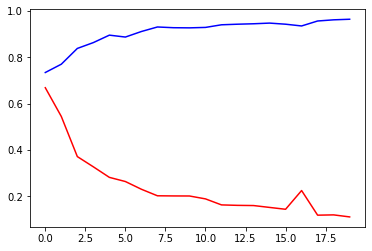

In [47]:
acc = history.history['acc']
loss = history.history['loss']
valacc = history.history['val_acc']
valloss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='accuracy')
plt.plot(epochs, loss, 'r', label='loss')
plt.plot(epochs, valacc, 'b--', label='val_accuracy')
plt.plot(epochs, valloss, 'r--', label='val_loss')
plt.title('accuracy and loss')
plt.legend()
  
plt.show()

**Predcition for Test**

In [48]:
import pandas as pd
import seaborn as sn
from sklearn.metrics import confusion_matrix, classification_report

In [49]:
# For prediction purposes
y_pred = model.predict_generator(test_generator, steps=test_generator.samples, verbose=1)
y_pred1 = np.argmax(y_pred, axis=1)

# y_test labeling
y_test = test_generator.labels

497/497 [==============================] - 5s 9ms/step


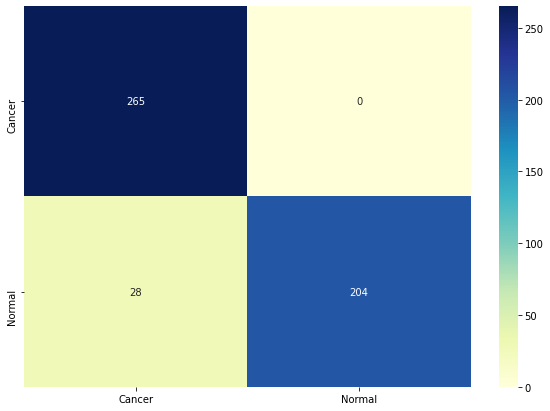

In [50]:
# calculate confusion matrix for the predicted dataset
cm = confusion_matrix(y_test, y_pred1)

# make a dataframe using cm array
df_cm = pd.DataFrame(cm, index = [i for i in classNames], columns = [i for i in classNames])

# plot confusion matrix
plt.figure(figsize = (10, 7))
sn.heatmap(df_cm, annot=True, fmt='d', cmap='YlGnBu')
plt.show()

In [51]:
# classification report generation: precision, recall, f1-score. 
print(classification_report(y_test, y_pred1, target_names=classNames))

              precision    recall  f1-score   support

      Cancer       0.90      1.00      0.95       265
      Normal       1.00      0.88      0.94       232

    accuracy                           0.94       497
   macro avg       0.95      0.94      0.94       497
weighted avg       0.95      0.94      0.94       497



**Model Interpretability with GradCAM**

In [52]:
import tensorflow as tf
import cv2

In [55]:
def grad_cam(input_model, image):
    preds = input_model.predict(image)
    predicted_label = np.argmax(preds[0])
    heatmap_model = keras.Model([input_model.inputs], [input_model.get_layer('block5_conv3').output, input_model.output])        
    
    with tf.GradientTape() as tape:
        last_conv_outputs, predictions = heatmap_model(image) # VGG16의 마지막 convolution layer의 특성맵과 예측 벡터
        output = predictions[:, predicted_label]              # 예측 벡터에서 해당 클래스 항목
        
    grads = tape.gradient(output, last_conv_outputs)      # VGG16의 마지막 convolution layer의 특성맵 출력에 대한 해당 클래스의 그래디언트
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))  # 특성맵 채널별 그래디언트 평균값이 담긴 (512,) 크기의 벡터
    
    last_conv_outputs = last_conv_outputs.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i, w in enumerate(pooled_grads):                    # 해당 클래스에 대한 채널의 중요도를 특성 맵 배열의 채널에 곱함
        last_conv_outputs[:,:,i] *= w
        
    heatmap = np.mean(last_conv_outputs, axis=-1) # 만들어진 특성 맵에서 채널 축을 따라 평균 --> 해당 클래스의 히트맵
    
    # 히트맵 후처리
    heatmap = np.maximum(heatmap, 0)               
    heatmap /= np.max(heatmap)
    heatmap = cv2.resize(heatmap, (224, 224))

    # 입력 영상을 8-bit RGB 영상으로 변환
    image = image[0, :]
    image -= np.min(image)
    image = np.minimum(image, 255)

    cam = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_JET)
    cam = np.float32(cam) + np.float32(image)
    cam = 255 * cam / np.max(cam)
    
    return np.uint8(cam), heatmap, predicted_label

In [56]:
dataDir = 'test' # 데이터 위치
classNames = sorted(os.listdir(dataDir)) # 각 클래스의 이름들
numClass = len(classNames)               # 클래스 개수

###
imageFiles = [[os.path.join(dataDir, classNames[i], x) for x in os.listdir(os.path.join(dataDir, classNames[i]))] 
              for i in range(numClass)]                   # 각 클래스별 파일 이름들
numEach = [len(imageFiles[i]) for i in range(numClass)]   # 각 클래스 별 파일 갯수

###
imageFilesList = [] # 모든 파일이름
imageClass = [] # 각각의 파일들에 대한 클래스
for i in range(numClass):
  imageFilesList.extend(imageFiles[i])
  imageClass.extend([i]*numEach[i])

### 
numTotal = len(imageClass) # 전체 파일 갯수
imageWidth, imageHeight = Image.open(imageFilesList[0]).size # 각 영상의 사이즈(width, height)

###
print("There are",numTotal,"images in",numClass,"distinct categories")
print("Label names:",classNames)
print("Label counts:",numEach)
print("Image dimensions:",imageWidth,"x",imageHeight)

There are 497 images in 2 distinct categories
Label names: ['Cancer', 'Normal']
Label counts: [265, 232]
Image dimensions: 123 x 109


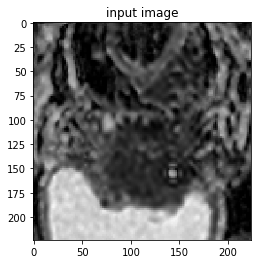

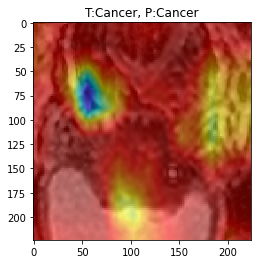

In [66]:
# Select a random query image+
inum = np.random.randint(numTotal)
qimage0 = load_img(imageFilesList[inum], target_size=(224, 224))
qimage  = img_to_array(qimage0)
qimage  = qimage.reshape((1, 224, 224, 3))
qimage  = vgg16.preprocess_input(qimage)

# Origianl Input image
plt.title('input image')
plt.imshow(qimage0)
plt.show()

# CAM 출력
cam, heatmap, plabel = grad_cam(model, qimage)
plt.title('T:'+classNames[imageClass[inum]]+', P:'+classNames[plabel])
plt.imshow(cam)
plt.show()